In [16]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import cvxpy as cp
import csv
import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EyeIK')
from InputStructures import *
from EyeCatch_implementation import *
from Ground_truth_implementation import *
from Oyekoya_implementation import *
from Andrist_implementation import *
from Goude_implementation import *
from Jin_implementation import *
from Itti_implementation import *
from Pejsa_implementation import *
import networkx as nx
from Proposed_model import *

import json
import numpy as np
import pickle
import os
import pandas as pd


In [17]:
%load_ext autoreload
%autoreload 1
%aimport EyeCatch_implementation
%aimport Oyekoya_implementation
%aimport Andrist_implementation
%aimport Goude_implementation
%aimport Ground_truth_implementation
%aimport Proposed_model
%aimport Jin_implementation
%aimport Itti_implementation
%aimport Pejsa_implementation
%aimport InputStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport Geometry_Util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper Functions

In [18]:
def output_motion(hk, ek, micro_saccade, outpath):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pickle.dump(out, f, protocol=2)
    print(outpath)
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[index]
        else:
            angle = self.input_json["input_target_angle"][index]
        pos = directions_from_rotation_angles(np.array([[angle, 0]]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])
def compare_kf_plot_hk(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    # index 0 = time
    # index 1 = sideways
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
    # plt.plot(ek2[:, 0], ek2[:, 1], 'r')
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        # find the largest time stamp in hk2 that is less than the final time stamp in hk1
        hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
        hk2_val = hk2_interp(hk1[:, 0])
    else:
        hk2 = hk2[:end]
    plt.plot(hk1[:, 0], hk2_val, 'b', label=name2)
    plt.plot(hk1[:, 0], hk1[:, 1], 'g', label=name1)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Neck angle (deg)")

    plt.show()  
def compare_kf_plot_ek(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    ek1 = np.array(ek1)[0]
    ek2 = np.array(ek2)[0]
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
        hk2 = hk2[:end]
        ek1 = ek1[:end]
        ek2 = ek2[:end]
    ek_angles1 = rotation_angles_frome_positions(ek1[:, 1:])
    ek_angles2 = rotation_angles_frome_positions(ek2[:, 1:])
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        ek_angles2_interp = interp1d(ek2[:, 0], ek_angles2[:, 0], axis=0, fill_value="extrapolate", bounds_error=False)
        ek_angles2_val = ek_angles2_interp(hk1[:, 0])
    plt.plot(hk1[:, 0], ek_angles1[:, 0] + hk1[:, 1], 'g', label=name1)
    plt.plot(hk1[:, 0], ek_angles2_val, 'b', label=name2)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Eye angle (deg)")
    plt.show()  
    
def compare_kf_error_hk(ek1, ek2, hk1, hk2, name1="GT"):
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0]
    # resample the second one to be the same length as the first
    hk2[:, 1:] = np.where(hk2[:, 1:] > 90, 90, hk2[:, 1:])
    hk2[:, 1:] = np.where(hk2[:, 1:] <= -90, -90, hk2[:, 1:])
    hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
    re_factor_hk2 = 1.0 * hk2_interp(hk1[:, 0])
    mse = np.mean((hk1[:, 1] - re_factor_hk2)**2)
    return mse
# compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed, name1="GT")
# Write a class that store head_trajectory, eye_trajectory, target_trajectory an input_target_times, input_target_angle
# the class should also read and write these data to a json file

class ExperimentData:
    # the init can be from the list of data or no information and read from file
    def __init__(self, head_trajectory, eye_trajectory, target_trajectory, input_target_times, input_target_angle):
        self.head_trajectory = head_trajectory
        self.eye_trajectory = eye_trajectory
        self.target_trajectory = target_trajectory
        self.input_target_times = input_target_times
        self.input_target_angle = input_target_angle
    def write_to_json(self, file_name):
        data = {}
        # self.head_trajectory is a 2D numpy array, convert that to be serializable with Json
        head_trajectory = []
        for i in range(0, self.head_trajectory.shape[0]):
            head_trajectory.append(self.head_trajectory[i].tolist())
        # do the sake for eye_trajectory and target_trajectory
        eye_trajectory = []
        for i in range(0, self.eye_trajectory.shape[0]):
            eye_trajectory.append(self.eye_trajectory[i].tolist())
        target_trajectory = []
        for i in range(0, self.target_trajectory.shape[0]):
            target_trajectory.append(self.target_trajectory[i].tolist())



        data["head_trajectory"] = head_trajectory
        data["eye_trajectory"] = eye_trajectory
        data["target_trajectory"] = target_trajectory
        data["input_target_times"] = self.input_target_times
        data["input_target_angle"] = [int(x) for x in self.input_target_angle]
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)
    # class method to read from json
    @classmethod
    def read_from_json(self, file_name):
        data = json.load(open(file_name, "r"))
        self.head_trajectory = np.array(data["head_trajectory"])
        self.eye_trajectory = np.array(data["eye_trajectory"])
        self.target_trajectory = np.array(data["target_trajectory"])
        self.input_target_times = np.array(data["input_target_times"])
        self.input_target_angle = np.array(data["input_target_angle"])
        return self

### DIspersion filter

In [19]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals


### Find Head Angle

In [20]:
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        



### find CHOR

In [21]:
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle
def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution



In [22]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration
    
def get_gaze_inputs_naive(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    # gaze_fixations_angles = gaze_fixations[:, 1]
    # gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

## parse data

In [25]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    """
    This function aligns the target and collected gaze data by removing the target data that is not collected
    """
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration
def get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
        # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y
    # plt.plot(target_dir[:, 2].tolist())
    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0.1, duraiton_threshold=0.0001)
    # find the number of nans in target_dir
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 3, duraiton_threshold=0.2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]


    # get the target durations from the experimental setup file
    target_present_duration = target_input["duration"]
    # valid_target_list = np.array(target_input["isTarget"])
    # valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    # target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    # target_fixation_angles = target_fixation_angles[valid_target_list]
    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    pre_fixation = len(target_fixation_angles)
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    post_fixation = len(target_fixation_angles)
    print("Pre-fixation: ", pre_fixation, "Post-fixation: ", post_fixation, "difference: ", pre_fixation - post_fixation)
    if three_target:
        # make sure the structure nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
            
        target_fixation_angles = np.insert(target_fixation_angles, added_index, 0, axis=0)
        target_present_duration = np.insert(target_present_duration, added_index, 1, axis=0)
        head_fixation_angles = np.insert(head_fixation_angles, added_index, 0, axis=0)
        fixation_angles = np.insert(fixation_angles, added_index, 0, axis=0)        
    return target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration

def get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_present_duration = target_input["duration"]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    
    
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)


    if three_target:
        # make sure the structure is nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
        for i in range(0, len(added_index)):
            list.insert(target_fixations_intervals, added_index[len(added_index)-1-i], [0, 0])
        return target_fixations_intervals
    else:
        return target_fixations_intervals
target_fixation_intervals = get_interval_per_instance(all_head_data[0], all_eye_data[0], all_target_data[0], all_target_input[0], True)


IndexError: list index out of range

# Load Data

In [26]:
def np_from_txt_aug(full_path):
    with open(full_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        rows = [row for row in reader]
    # Process rows to ensure they all have 4 elements
    filtered_rows = []
    for row in rows:
        # remove spaces 
        row_no_space = []
        for i in range(0, len(row)):
            if row[i] != "" and row[i] != " ":
                row_no_space.append(row[i])
        while len(row_no_space) < 4:
            row_no_space.append(np.nan)  # Append NaN for missing values
        filtered_rows.append(row_no_space)
    # Convert to NumPy array
    data = np.array(filtered_rows, dtype=float)
    return data

In [27]:
input_dir = "/Users/evanpan/Desktop/collected_data_VR"
input_dirs = []
users = os.listdir(input_dir)
for i in range(len(users)):
    if users[i].startswith("user"):
        input_dirs.append(os.path.join(input_dir, users[i]))
all_trials = []
recording_file_names = ["random_condition", "wackamole", "see_through_task"]
for input_dir in input_dirs:
    # to store the trials of a single subject
    trial_per_subject = {}
    dirs = os.listdir(input_dir)
    # get duration of each trial:
    total_length = 0
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    for fileName in recording_file_names:
        all_eye_data = []
        all_head_data = []
        all_target_data = []
        all_target_input = []

        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np_from_txt_aug(fullPath)
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np_from_txt_aug(fullPath)
        
        if fileName == "random_condition":
            setupFileName = os.path.join(*[input_dir, fileName+".json"])
            data_type = "target_pos"
            fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
            target_data = np_from_txt_aug(fullPath)
            all_target_data.append(target_data)
            trial_per_subject[fileName] = [all_eye_data, all_head_data, all_target_data, all_target_input]
            target_input = json.load(open(setupFileName, "r"))
            all_target_input.append(target_input)
        else:
            trial_per_subject[fileName] = [all_eye_data, all_head_data]
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        
        
    all_trials.append(trial_per_subject)

# parse the data (the wackamole data has some corrupted timestamps (the recording doesn't properly stop after the user take off the headset))
recording_file_names = ["random_condition", "wackamole", "see_through_task"]
# recording_file_names = ["wackamole"]
for i in range(0, len(all_trials)):
    for j in recording_file_names:
        subject_i_type_j_data = all_trials[i][j][0][0]
        # the timing is screwed past certain index, must filter it out
        bad_apple = -1
        for t in range(0, subject_i_type_j_data.shape[0]):
            if subject_i_type_j_data[t, 0] - subject_i_type_j_data[t-1, 0] > 0.1:
                bad_apple = t
                break
        if bad_apple > 0:
            subject_i_type_j_data = subject_i_type_j_data[0:bad_apple-1]
        all_trials[i][j][0][0] = subject_i_type_j_data
        all_trials[i][j][1][0] = all_trials[i][j][1][0][0:subject_i_type_j_data.shape[0]]

## Total length of data

In [28]:
total_length = 0 
total_clip_count = 0
total_frames = 0
recording_file_names = ["random_condition", "wackamole", "see_through_task"]
# recording_file_names = ["wackamole"]
for i in range(0, len(all_trials)):
    for j in recording_file_names:
        # get the data
        subject_i_type_j_data = all_trials[i][j][0][0]
        total_length += subject_i_type_j_data[-1, 0] - subject_i_type_j_data[0, 0]
        total_frames += subject_i_type_j_data.shape[0]
        total_clip_count += 1
print("total length (minutes): ", total_length/60)
print("total frames: ", total_frames)
print("average length (minutes): ", total_length/total_clip_count/60)
print("average frames: ", total_frames/total_clip_count)


total length (minutes):  82.549455315
total frames:  355894
average length (minutes):  1.8344323403333334
average frames:  7908.7555555555555


# Evaluate existing models

## Proposed model

In [1]:
import networkx as nx
from Proposed_model import *
def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1, center_bias=0.4):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1 - np.exp(-0.8*dwell_time)) # this is higher for shorter dwell times)
    dwell_time_factor0 = np.exp(-0.8*dwell_time) # this is higher for longer dwell times
    return dwell_time_factor0 * np.linalg.norm(angle_j - angle1) + dwell_time_factor1 * np.linalg.norm(angle_j - angle0) + center_bias *np.abs(angle_j)
def head_moving_cost_function(prev, current, dwell_time, laziness=0.6):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current)
    if np.linalg.norm(prev - current) <= 4:
        cost = 0
    # but this cost is lowered in the direction of the midline
    # return np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) * cost
    return np.exp(-0.8*dwell_time) * cost
def create_graph(self, laziness=0.5, center_bias=0.4):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 90
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, len(gaze_intervals)):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 3):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1, center_bias))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 3):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j, dwell_time, laziness=laziness))
        G.add_node((gaze_positions.shape[0], int(gaze_positions[-1][dimension])), value=0)
        for j_prev in range(-range_limit, range_limit,3):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], int(gaze_positions[-1][dimension])), weight=head_moving_cost_function(j_prev, j, dwell_time))
        graphs.append(G)
    return graphs
def optimize_head_pos(self, saccade_generator, laziness=0.54, center_bias=1.2):
    G_0, G_1 = create_graph(self, laziness, center_bias)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][0])), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][1])), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 

ModuleNotFoundError: No module named 'Proposed_model'

## For controlled target-looking example

In [30]:
OUTPUT_ROOT = "../animation_data"

In [31]:
def remove_row_containing_nan(arr):
    return arr[~np.isnan(arr).any(axis=1)]


In [40]:
import time
input_seq0, gaze_pos, input_seq1 = input_sequence[0], gaze_positions, input_sequence[1]

print(len(gaze_pos), input_seq0.shape, input_seq1.shape)
for i in range(1, 5):
    start = time.time()
    saccade_generator = Proposed_saccade_generator_with_graph(input_seq0[:i], gaze_pos[:i], input_seq1[:i], internal_model)
    print(input_seq0[:i].shape)
    ek_proposed_graph, hk_proposed_graph, micro_saccade_proposed_graph = saccade_generator.compute(optimize_head_pos(saccade_generator, saccade_generator)[1])
    end = time.time()
    print("Time taken: ", end-start)
    # output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn])))

420 (420,) (420,)
(1,)
Time taken:  0.021639347076416016
(2,)
Time taken:  0.0477750301361084
(3,)
Time taken:  0.07580423355102539
(4,)
Time taken:  0.1161189079284668


In [32]:
from sklearn.metrics import mean_squared_error
import pandas as pd
target_look_at_error_dict = {}
experiment_names = ["random_condition"]
nnn = 0
for id_i in range(0, len(input_dirs)):
    input_dir = input_dirs[id_i]
    fileName = recording_file_names[nnn]
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    min_length_head_and_eye = int(np.minimum(eye_trajectory.shape[0], head_trajectory.shape[0]))
    eye_trajectory = eye_trajectory[:min_length_head_and_eye]
    head_trajectory = head_trajectory[:min_length_head_and_eye]
    target_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][2][0]))
    target_input = all_trials[id_i][fileName][3][0]
    # input_json_0 = ExperimentData(eye_trajectory=eye_trajectory, head_trajectory=head_trajectory, target_trajectory=target_trajectory, input_target_times=target_input["duration"], input_target_angle=target_input["angle"])
    input_json_0 = {"eye_trajectory": eye_trajectory, "head_trajectory": head_trajectory, "target_trajectory": target_trajectory, "input_target_times": target_input["duration"], "input_target_angle": target_input["angle"]}
    internal_model_0 = InternalModelFromCapture(input_json_0)
    sequence_0 = []
    for i in range(0, len(input_json_0["input_target_angle"])):
        sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
    input_json = input_json_0
    sequence = sequence_0
    input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
    internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
    for i in range(0, input_sequence.shape[1]):
        input_sequence[1][i] = int(i)
    gaze_positions = []
    for i in range(0, input_sequence.shape[1]):
        gaze_positions.append(internal_model.estimate_target_pose(i))
    # get ground_truth head_keyframes:
    saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
    gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
    output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get eye_catch head_keyframes:
    saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_eye_catch, hk_eye_catch, micro_saccade_eye_catch = saccade_generator.compute()
    output_motion(hk_eye_catch, ek_eye_catch, micro_saccade_eye_catch, os.path.join(OUTPUT_ROOT, "EyeCatch_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get oyekoya head_keyframes:
    saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_oyekoya, hk_oyekoya, micro_saccade_oyekoya = saccade_generator.compute()
    output_motion(hk_oyekoya, ek_oyekoya, micro_saccade_oyekoya, os.path.join(OUTPUT_ROOT, "Oyekoya_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get andrist head_keyframes:
    saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_andrist, hk_andrist, micro_saccade_andrist = saccade_generator.compute()
    output_motion(hk_andrist, ek_andrist, micro_saccade_andrist, os.path.join(OUTPUT_ROOT, "Andrist_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get goude head_keyframes:
    saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_goude, hk_goude, micro_saccade_goude = saccade_generator.compute()
    output_motion(hk_goude, ek_goude, micro_saccade_goude, os.path.join(OUTPUT_ROOT, "Goude_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get jin head_keyframes:
    saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, root_dir="../")
    ek_jin, hk_jin, micro_saccade_jin = saccade_generator.compute()
    output_motion(hk_jin, ek_jin, micro_saccade_jin, os.path.join(OUTPUT_ROOT, "Jin_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get itti head_keyframes:
    saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_itti, hk_itti, micro_saccade_itti = saccade_generator.compute()
    output_motion(hk_itti, ek_itti, micro_saccade_itti, os.path.join(OUTPUT_ROOT, "Itti_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get pejsa head_keyframes:
    saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_pejsa, hk_pejsa, micro_saccade_pejsa = saccade_generator.compute()
    output_motion(hk_pejsa, ek_pejsa, micro_saccade_pejsa, os.path.join(OUTPUT_ROOT, "Pejsa_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed graph head_keyframes:
    saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed_graph, hk_proposed_graph, micro_saccade_proposed_graph = saccade_generator.compute(optimize_head_pos(saccade_generator, saccade_generator)[1])
    output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed head_keyframes:
    saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed, hk_proposed, micro_saccade_proposed = saccade_generator.compute()
    output_motion(hk_proposed, ek_proposed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    
    # for each model, compute the error and save it in error_dict
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]] = {}
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]]["GT"] = compare_kf_error_hk(gt_ek, gt_ek, gt_hk, gt_hk)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["EyeCatch"] = compare_kf_error_hk(gt_ek, ek_eye_catch, gt_hk, hk_eye_catch)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Oyekoya"] = compare_kf_error_hk(gt_ek, ek_oyekoya, gt_hk, hk_oyekoya)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Andrist"] = compare_kf_error_hk(gt_ek, ek_andrist, gt_hk, hk_andrist)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Goude"] = compare_kf_error_hk(gt_ek, ek_goude, gt_hk, hk_goude)
    target_look_at_error_dict["participant_{}_".format(id_i)
            
                + experiment_names[nnn]]["Jin"] = compare_kf_error_hk(gt_ek, ek_jin, gt_hk, hk_jin)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Itti"] = compare_kf_error_hk(gt_ek, ek_itti, gt_hk, hk_itti)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Pejsa"] = compare_kf_error_hk(gt_ek, ek_pejsa, gt_hk, hk_pejsa)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Proposed"] = compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed)
    target_look_at_error_dict["participant_{}_".format(id_i)
                        + experiment_names[nnn]]["Proposed_graph"] = compare_kf_error_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph)
    # save error_dict
    with open(os.path.join(OUTPUT_ROOT, "error_dict_random_{}.json".format(id_i)), 'w') as f:
        json.dump(target_look_at_error_dict, f)


yeet
../animation_data/GT_0_random_condition.pkl
../animation_data/EyeCatch_0_random_condition.pkl
../animation_data/Oyekoya_0_random_condition.pkl
../animation_data/Andrist_0_random_condition.pkl


/Users/evanpan/Documents/GitHub/EvansToolBox/Utils/Geometry_Util.py:47: RuntimeWarning: invalid value encountered in divide
  out = arr / mag
/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


../animation_data/Goude_0_random_condition.pkl
../animation_data/Jin_0_random_condition.pkl


/Users/evanpan/Documents/GitHub/EyeIK/Itti_implementation.py:111: RuntimeWarning: invalid value encountered in divide
  v = v / np.sum(v)


../animation_data/Itti_0_random_condition.pkl
../animation_data/Pejsa_0_random_condition.pkl


KeyboardInterrupt: 

## For wackamole example

In [100]:
from sklearn.metrics import mean_squared_error
import pandas as pd
target_look_at_error_dict = {}
experiment_names = ["wackamole"]
nnn = 0
for id_i in range(0, len(input_dirs)):
    input_dir = input_dirs[id_i]
    fileName = "wackamole"
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    min_length_head_and_eye = int(np.minimum(eye_trajectory.shape[0], head_trajectory.shape[0]))
    eye_trajectory = eye_trajectory[:min_length_head_and_eye]
    head_trajectory = head_trajectory[:min_length_head_and_eye]
    # input_json_0 = ExperimentData(eye_trajectory=eye_trajectory, head_trajectory=head_trajectory, target_trajectory=target_trajectory, input_target_times=target_input["duration"], input_target_angle=target_input["angle"])
    input_json_0 = {"eye_trajectory": eye_trajectory, "head_trajectory": head_trajectory, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
    internal_model_0 = InternalModelFromCapture(input_json_0)
    sequence_0 = []
    for i in range(0, len(input_json_0["input_target_angle"])):
        sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
    input_json = input_json_0
    input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
    internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
    for i in range(0, input_sequence.shape[1]):
        input_sequence[1][i] = int(i)
    gaze_positions = []
    for i in range(0, input_sequence.shape[1]):
        gaze_positions.append(internal_model.estimate_target_pose(i))
    # get ground_truth head_keyframes:
    saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
    gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
    output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get eye_catch head_keyframes:
    saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_eye_catch, hk_eye_catch, micro_saccade_eye_catch = saccade_generator.compute()
    output_motion(hk_eye_catch, ek_eye_catch, micro_saccade_eye_catch, os.path.join(OUTPUT_ROOT, "EyeCatch_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get oyekoya head_keyframes:
    saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_oyekoya, hk_oyekoya, micro_saccade_oyekoya = saccade_generator.compute()
    output_motion(hk_oyekoya, ek_oyekoya, micro_saccade_oyekoya, os.path.join(OUTPUT_ROOT, "Oyekoya_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get andrist head_keyframes:
    saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_andrist, hk_andrist, micro_saccade_andrist = saccade_generator.compute()
    output_motion(hk_andrist, ek_andrist, micro_saccade_andrist, os.path.join(OUTPUT_ROOT, "Andrist_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get goude head_keyframes:
    saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_goude, hk_goude, micro_saccade_goude = saccade_generator.compute()
    output_motion(hk_goude, ek_goude, micro_saccade_goude, os.path.join(OUTPUT_ROOT, "Goude_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get jin head_keyframes:
    saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, root_dir="../")
    ek_jin, hk_jin, micro_saccade_jin = saccade_generator.compute()
    output_motion(hk_jin, ek_jin, micro_saccade_jin, os.path.join(OUTPUT_ROOT, "Jin_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get itti head_keyframes:
    saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_itti, hk_itti, micro_saccade_itti = saccade_generator.compute()
    output_motion(hk_itti, ek_itti, micro_saccade_itti, os.path.join(OUTPUT_ROOT, "Itti_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get pejsa head_keyframes:
    saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_pejsa, hk_pejsa, micro_saccade_pejsa = saccade_generator.compute()
    output_motion(hk_pejsa, ek_pejsa, micro_saccade_pejsa, os.path.join(OUTPUT_ROOT, "Pejsa_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed graph head_keyframes:
    saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed_graph, hk_proposed_graph, micro_saccade_proposed_graph = saccade_generator.compute(optimize_head_pos(saccade_generator, saccade_generator)[1])
    output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed head_keyframes:
    saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed, hk_proposed, micro_saccade_proposed = saccade_generator.compute()
    output_motion(hk_proposed, ek_proposed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    
    # for each model, compute the error and save it in error_dict
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]] = {}
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]]["GT"] = compare_kf_error_hk(gt_ek, gt_ek, gt_hk, gt_hk)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["EyeCatch"] = compare_kf_error_hk(gt_ek, ek_eye_catch, gt_hk, hk_eye_catch)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Oyekoya"] = compare_kf_error_hk(gt_ek, ek_oyekoya, gt_hk, hk_oyekoya)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Andrist"] = compare_kf_error_hk(gt_ek, ek_andrist, gt_hk, hk_andrist)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Goude"] = compare_kf_error_hk(gt_ek, ek_goude, gt_hk, hk_goude)
    target_look_at_error_dict["participant_{}_".format(id_i)
            
                + experiment_names[nnn]]["Jin"] = compare_kf_error_hk(gt_ek, ek_jin, gt_hk, hk_jin)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Itti"] = compare_kf_error_hk(gt_ek, ek_itti, gt_hk, hk_itti)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Pejsa"] = compare_kf_error_hk(gt_ek, ek_pejsa, gt_hk, hk_pejsa)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Proposed"] = compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed)
    target_look_at_error_dict["participant_{}_".format(id_i)
                        + experiment_names[nnn]]["Proposed_graph"] = compare_kf_error_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph)
    print("proposed_model_error: ", target_look_at_error_dict["participant_{}_".format(id_i) + experiment_names[nnn]]["Proposed_graph"])
    print("Itti_error: ", target_look_at_error_dict["participant_{}_".format(id_i) + experiment_names[nnn]]["Itti"])
    # save error_dict
    with open(os.path.join(OUTPUT_ROOT, "error_dict_wackamole_{}.json".format(id_i)), 'w') as f:
        json.dump(target_look_at_error_dict, f)


yeet
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/GT_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/EyeCatch_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Oyekoya_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Andrist_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Goude_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Jin_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Itti_0_wackamole.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Pejsa_0_wackamole.pkl


KeyboardInterrupt: 

## For See through example

In [112]:
from sklearn.metrics import mean_squared_error
import pandas as pd
target_look_at_error_dict = {}
experiment_names = ["see_through_task"]
nnn = 0
for id_i in range(0, len(input_dirs)):
    input_dir = input_dirs[id_i]
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    fileName = experiment_names[nnn]
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    min_length_head_and_eye = int(np.minimum(eye_trajectory.shape[0], head_trajectory.shape[0]))
    eye_trajectory = eye_trajectory[:min_length_head_and_eye]
    head_trajectory = head_trajectory[:min_length_head_and_eye]
    # input_json_0 = ExperimentData(eye_trajectory=eye_trajectory, head_trajectory=head_trajectory, target_trajectory=target_trajectory, input_target_times=target_input["duration"], input_target_angle=target_input["angle"])
    input_json_0 = {"eye_trajectory": eye_trajectory, "head_trajectory": head_trajectory, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
    internal_model_0 = InternalModelFromCapture(input_json_0)
    sequence_0 = []
    for i in range(0, len(input_json_0["input_target_angle"])):
        sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
    input_json = input_json_0
    input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
    internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
    for i in range(0, input_sequence.shape[1]):
        input_sequence[1][i] = int(i)
    gaze_positions = []
    for i in range(0, input_sequence.shape[1]):
        gaze_positions.append(internal_model.estimate_target_pose(i))
    # get ground_truth head_keyframes:
    saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
    gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
    output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get eye_catch head_keyframes:
    saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_eye_catch, hk_eye_catch, micro_saccade_eye_catch = saccade_generator.compute()
    output_motion(hk_eye_catch, ek_eye_catch, micro_saccade_eye_catch, os.path.join(OUTPUT_ROOT, "EyeCatch_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get oyekoya head_keyframes:
    saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_oyekoya, hk_oyekoya, micro_saccade_oyekoya = saccade_generator.compute()
    output_motion(hk_oyekoya, ek_oyekoya, micro_saccade_oyekoya, os.path.join(OUTPUT_ROOT, "Oyekoya_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get andrist head_keyframes:
    saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_andrist, hk_andrist, micro_saccade_andrist = saccade_generator.compute()
    output_motion(hk_andrist, ek_andrist, micro_saccade_andrist, os.path.join(OUTPUT_ROOT, "Andrist_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get goude head_keyframes:
    saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_goude, hk_goude, micro_saccade_goude = saccade_generator.compute()
    output_motion(hk_goude, ek_goude, micro_saccade_goude, os.path.join(OUTPUT_ROOT, "Goude_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get jin head_keyframes:
    saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, root_dir="../")
    ek_jin, hk_jin, micro_saccade_jin = saccade_generator.compute()
    output_motion(hk_jin, ek_jin, micro_saccade_jin, os.path.join(OUTPUT_ROOT, "Jin_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get itti head_keyframes:
    saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_itti, hk_itti, micro_saccade_itti = saccade_generator.compute()
    output_motion(hk_itti, ek_itti, micro_saccade_itti, os.path.join(OUTPUT_ROOT, "Itti_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get pejsa head_keyframes:
    saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
    ek_pejsa, hk_pejsa, micro_saccade_pejsa = saccade_generator.compute()
    output_motion(hk_pejsa, ek_pejsa, micro_saccade_pejsa, os.path.join(OUTPUT_ROOT, "Pejsa_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed graph head_keyframes:
    saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed_graph, hk_proposed_graph, micro_saccade_proposed_graph = saccade_generator.compute(optimize_head_pos(saccade_generator, saccade_generator, 0.95)[1])
    output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get proposed head_keyframes:
    saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
    ek_proposed, hk_proposed, micro_saccade_proposed = saccade_generator.compute()
    output_motion(hk_proposed, ek_proposed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    
    # for each model, compute the error and save it in error_dict
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]] = {}
    target_look_at_error_dict["participant_{}_".format(id_i) 
            + experiment_names[nnn]]["GT"] = compare_kf_error_hk(gt_ek, gt_ek, gt_hk, gt_hk)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["EyeCatch"] = compare_kf_error_hk(gt_ek, ek_eye_catch, gt_hk, hk_eye_catch)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Oyekoya"] = compare_kf_error_hk(gt_ek, ek_oyekoya, gt_hk, hk_oyekoya)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Andrist"] = compare_kf_error_hk(gt_ek, ek_andrist, gt_hk, hk_andrist)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Goude"] = compare_kf_error_hk(gt_ek, ek_goude, gt_hk, hk_goude)
    target_look_at_error_dict["participant_{}_".format(id_i)
            
                + experiment_names[nnn]]["Jin"] = compare_kf_error_hk(gt_ek, ek_jin, gt_hk, hk_jin)
    target_look_at_error_dict["participant_{}_".format(id_i)
                + experiment_names[nnn]]["Itti"] = compare_kf_error_hk(gt_ek, ek_itti, gt_hk, hk_itti)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Pejsa"] = compare_kf_error_hk(gt_ek, ek_pejsa, gt_hk, hk_pejsa)
    target_look_at_error_dict["participant_{}_".format(id_i)
                    + experiment_names[nnn]]["Proposed"] = compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed)
    target_look_at_error_dict["participant_{}_".format(id_i)
                        + experiment_names[nnn]]["Proposed_graph"] = compare_kf_error_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph)
    # save error_dict
    with open(os.path.join(OUTPUT_ROOT, "error_dict_seethrough_{}.json".format(id_i)), 'w') as f:
        json.dump(target_look_at_error_dict, f)


yeet
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/GT_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/EyeCatch_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Oyekoya_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Andrist_0_see_through_task.pkl


/Users/evanpan/Documents/GitHub/EvansToolBox/Utils/Geometry_Util.py:47: RuntimeWarning: invalid value encountered in divide
  out = arr / mag
/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Goude_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Jin_0_see_through_task.pkl


/Users/evanpan/Documents/GitHub/EyeIK/Itti_implementation.py:111: RuntimeWarning: invalid value encountered in divide
  v = v / np.sum(v)


/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Itti_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Pejsa_0_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Proposed_graph_0_see_through_task.pkl


/Users/evanpan/Documents/GitHub/EvansToolBox/Utils/Geometry_Util.py:123: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)


/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Proposed_0_see_through_task.pkl
yeet
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/GT_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/EyeCatch_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Oyekoya_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Andrist_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Goude_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Jin_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Itti_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Pejsa_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Proposed_graph_1_see_through_task.pkl
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/Proposed_1_see_through_task.pkl
yeet
/Users/evanpan/Documents/GitHub/EyeIK/animation_data/GT_2_see_through_ta

## show overall errors

In [113]:
def compute_mean_error_fn(input_dict_gt, input_dict_alt, delta=0):
    mean_error = 0
    hk_gt = input_dict_gt["head_frames"]
    ek_gt = input_dict_gt["eye_frames"]
    hk_alt = input_dict_alt["head_frames"]
    hk_alt_copy = np.array(hk_alt.copy())
    hk_alt_copy[0, :, 0] += delta
    ek_alt = input_dict_alt["eye_frames"]
    ek_alt_copy = np.array(ek_alt.copy())
    ek_alt_copy[0, :, 0] += delta
    error = compare_kf_error_hk(ek_gt, ek_alt_copy, hk_gt, hk_alt_copy)
    return error

In [114]:
drive = "F:/"
dribe = "/Volumes/EVAN_DISK/"
participant_number = ["1", "0", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
experiment_names = ["random_condition", "see_through_task", "wackamole"]
# experiment_names = ["onward_condition_pilot"]
file_name_template = "MASC/EYE_IK/ground_truth/Experiment_{}_{}.json"
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
OUTPUT_ROOT = "/Users/evanpan/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"
# print out the error for all the models for all trials

mean_error_double_look = {}
mean_error_onward = {}
mean_error_random = {}
mean_error_tennis = {}
mean_error_wackamole = {}
mean_error_seethrough = {}
compute_mean_error = True

main_error_dict = {}
for nnn in range (len(experiment_names)):
    error_dict = {}
    for mmm in range (len(participant_number)):
        # load the error dict
        if participant_number[mmm] == "13":
            continue
        id_i = participant_number[mmm]
        # try and load all the key-frames
        proposed_graph_kf_path = os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn]))

        proposed_kf_path = os.path.join(OUTPUT_ROOT, "Proposed_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        pejsa_kf_path = os.path.join(OUTPUT_ROOT, "Pejsa_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        itti_kf_path = os.path.join(OUTPUT_ROOT, "Itti_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        jin_kf_path = os.path.join(OUTPUT_ROOT, "Jin_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        goude_kf_path = os.path.join(OUTPUT_ROOT, "Goude_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        andrist_kf_path = os.path.join(OUTPUT_ROOT, "Andrist_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        oyekoya_kf_path = os.path.join(OUTPUT_ROOT, "Oyekoya_{}_{}.pkl".format(id_i, experiment_names[nnn]))    
        eye_catch_kf_path = os.path.join(OUTPUT_ROOT, "EyeCatch_{}_{}.pkl".format(id_i, experiment_names[nnn]))
        gt_kf_path = os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(id_i, experiment_names[nnn]))

        # load the key-frames
        input_dict_gt = pickle.load(open(gt_kf_path, "rb"))
        input_dict_eye_catch = pickle.load(open(eye_catch_kf_path, "rb"))
        input_dict_oyekoya = pickle.load(open(oyekoya_kf_path, "rb"))
        input_dict_andrist = pickle.load(open(andrist_kf_path, "rb"))
        input_dict_goude = pickle.load(open(goude_kf_path, "rb"))
        input_dict_jin = pickle.load(open(jin_kf_path, "rb"))
        input_dict_itti = pickle.load(open(itti_kf_path, "rb"))
        input_dict_pejsa = pickle.load(open(pejsa_kf_path, "rb"))
        input_dict_proposed = pickle.load(open(proposed_kf_path, "rb"))
        input_dict_proposed_graph = pickle.load(open(proposed_graph_kf_path, "rb"))

        # do a line search to shift the proposed graph to minimize the error
        delta = -0.2
        best_delta = delta
        min_error = np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed_graph))
        for i in range(0, 20):
            delta += delta * 0.1
            error = np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed_graph, delta))
            if error < min_error:
                min_error = error
                best_delta = delta 
        try:
            error_dict["proposed_graph"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed_graph, best_delta)))
        except:
            error_dict["proposed_graph"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed_graph, best_delta))]
        try:
            error_dict["itti"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_itti)))
        except:
            error_dict["itti"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_itti))]
        try:
            error_dict["jin"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_jin)))
        except:
            error_dict["jin"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_jin))]
        try:
            error_dict["goude"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_goude)))
        except:
            error_dict["goude"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_goude))]
        try:
            error_dict["andrist"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_andrist)))
        except:
            error_dict["andrist"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_andrist))]
        try:
            error_dict["oyekoya"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_oyekoya)))
        except:
            error_dict["oyekoya"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_oyekoya))]
        try:
            error_dict["eye_catch"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_eye_catch)))
        except:
            error_dict["eye_catch"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_eye_catch))]
        try:
            error_dict["proposed"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed)))
        except:
            error_dict["proposed"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_proposed))]
        try:
            error_dict["pejsa"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_pejsa)))
        except:
            error_dict["pejsa"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_pejsa))]
        try:
            error_dict["GT"].append(np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_gt)))
        except:
            error_dict["GT"] = [np.sqrt(compute_mean_error_fn(input_dict_gt, input_dict_gt))]
    main_error_dict[experiment_names[nnn]] = error_dict


# print out the mean error for each condition
if compute_mean_error:
    print("mean_error_random")
    for key in main_error_dict["random_condition"]:
        print(key, np.mean(main_error_dict["random_condition"][key]))
    print("mean_error_seethrough")
    for key in main_error_dict["see_through_task"]:
        print(key, np.mean(main_error_dict["see_through_task"][key]))
    print("mean_error_wackamole")
    for key in main_error_dict["wackamole"]:
        print(key, np.mean(main_error_dict["wackamole"][key]))
            

mean_error_random
proposed_graph 9.47704462078512
itti 20.091772400172886
jin 29.08044955875897
goude 28.62517462038559
andrist 22.662107496563724
oyekoya 31.6412208361703
eye_catch 21.35904005161501
proposed 27.443610412276662
pejsa 20.090024982230698
GT 0.03473273715731498
mean_error_seethrough
proposed_graph 13.930194408834959
itti 24.64665283104161
jin 24.23770598987034
goude 24.598011637058065
andrist 25.695384167833517
oyekoya 13.965738478966934
eye_catch 26.097174499248485
proposed 17.864463833597195
pejsa 24.463381642558787
GT 1.6020835349729814e-18
mean_error_wackamole
proposed_graph 21.797023875787986
itti 39.19143527468156
jin 49.89542624403725
goude 54.25119598260411
andrist 55.03799182479493
oyekoya 45.35777368019002
eye_catch 46.59846255842694
proposed 59.170780512375245
pejsa 39.086710301194536
GT 3.2518019080227996


# Qualitatively show some graphs Because something is wrong

yeet


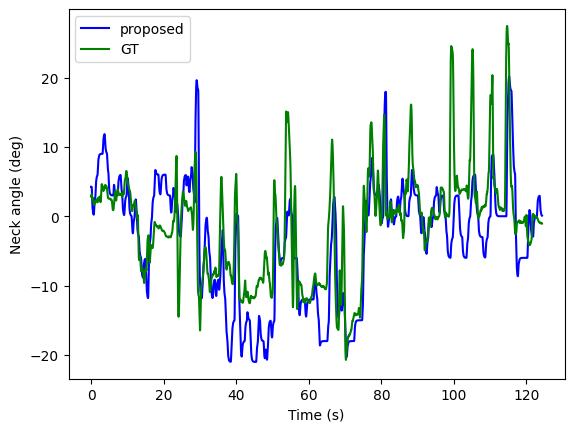

(5370, 3)
(5370, 3)
proposed: 6.350792302776498
(8055, 3)
(8055, 3)
oyekoya: 7.888861778486461
yeet


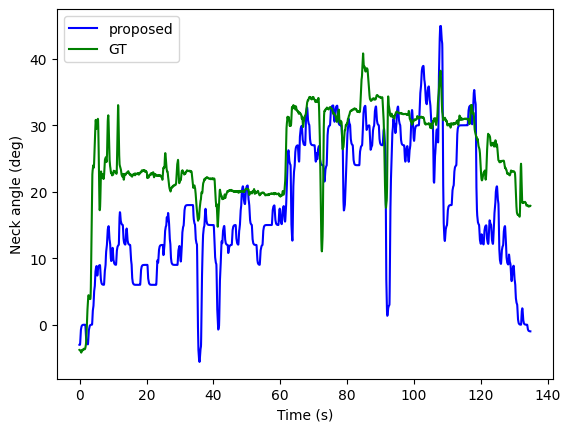

(5747, 3)
(5747, 3)
proposed: 10.016958476487632
(8620, 3)
(8620, 3)
oyekoya: 26.342764233240526
yeet


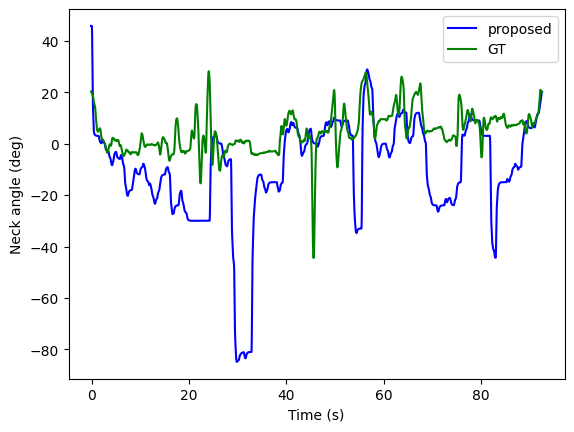

(4100, 3)
(4100, 3)
proposed: 23.934642398783904
(6149, 3)
(6149, 3)
oyekoya: 9.301829479458647
yeet


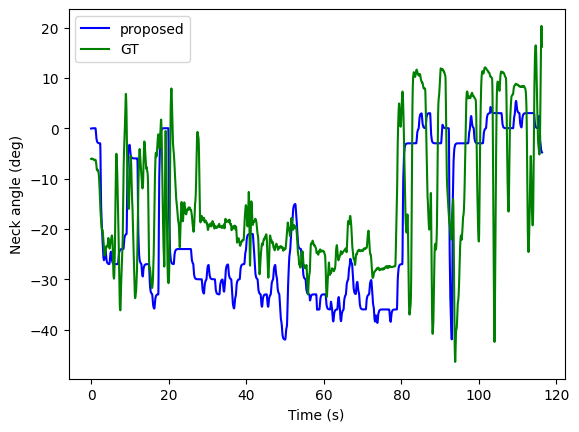

(5017, 3)
(5017, 3)
proposed: 13.239299984326546
(7525, 3)
(7525, 3)
oyekoya: 19.962411285103435
yeet


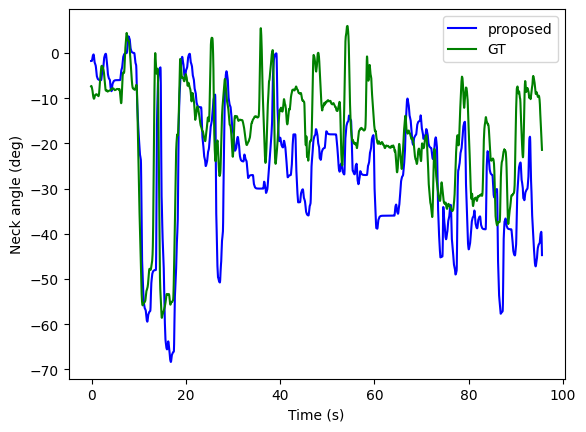

(4216, 3)
(4216, 3)
proposed: 13.57976138070058
(6323, 3)
(6323, 3)
oyekoya: 22.11430281077919
yeet


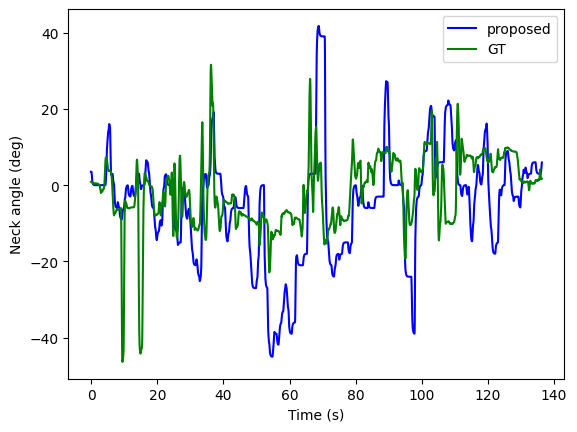

(5853, 3)
(5853, 3)
proposed: 14.011914506132431
(8778, 3)
(8778, 3)
oyekoya: 9.536760997739533
yeet


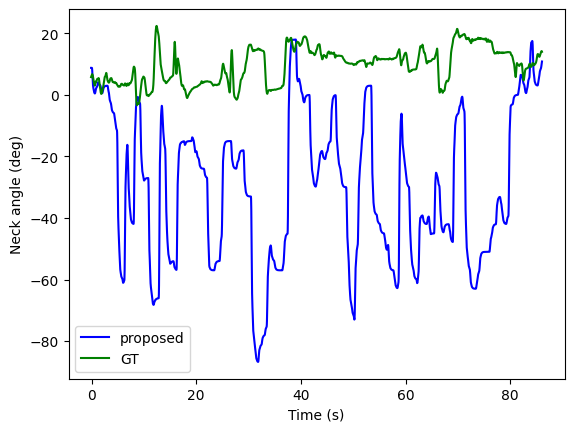

(3844, 3)
(3844, 3)
proposed: 47.04581158450667
(5765, 3)
(5765, 3)
oyekoya: 11.221004208725041
yeet


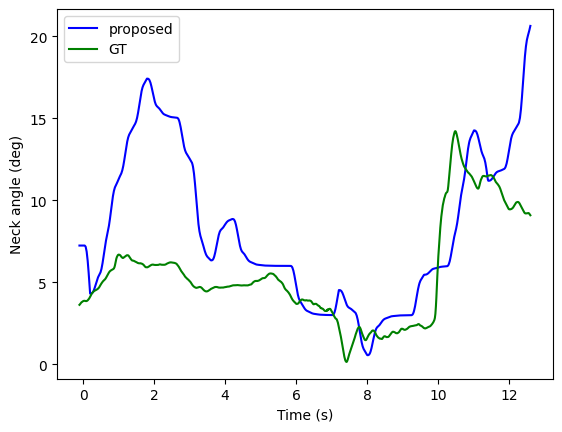

(888, 3)
(888, 3)
proposed: 4.516233911650683
(1331, 3)
(1331, 3)
oyekoya: 6.3348254999333635
yeet


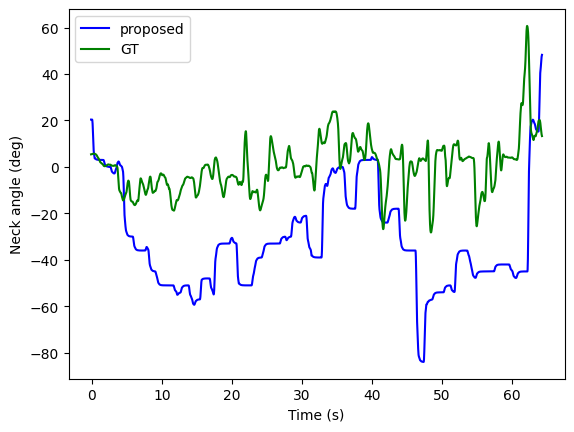

(2952, 3)
(2952, 3)
proposed: 37.95344504247238
(4428, 3)
(4428, 3)
oyekoya: 11.45634629655496
yeet


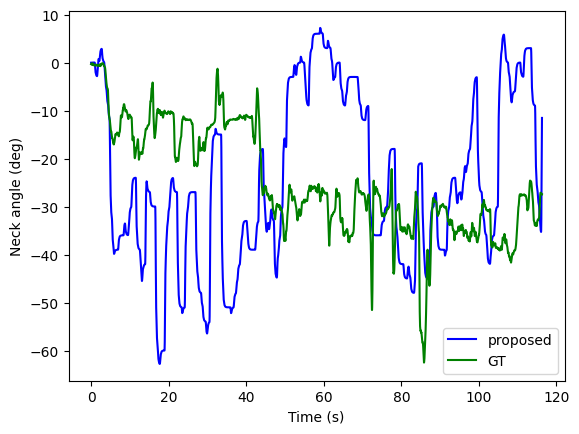

(5038, 3)
(5038, 3)
proposed: 23.05073302346277
(7556, 3)
(7556, 3)
oyekoya: 27.300598113407244
yeet


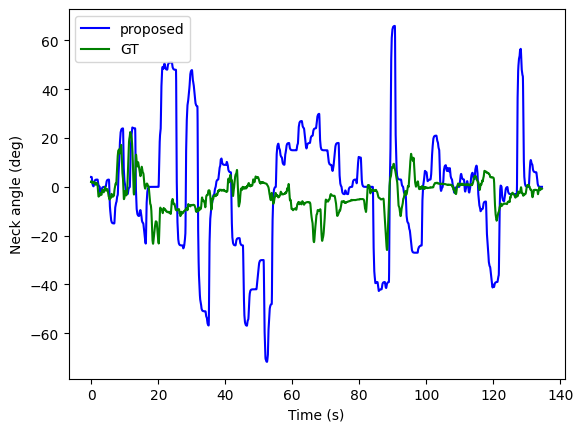

(5777, 3)
(5777, 3)
proposed: 26.447436444163955
(8665, 3)
(8665, 3)
oyekoya: 7.032706877604975
yeet


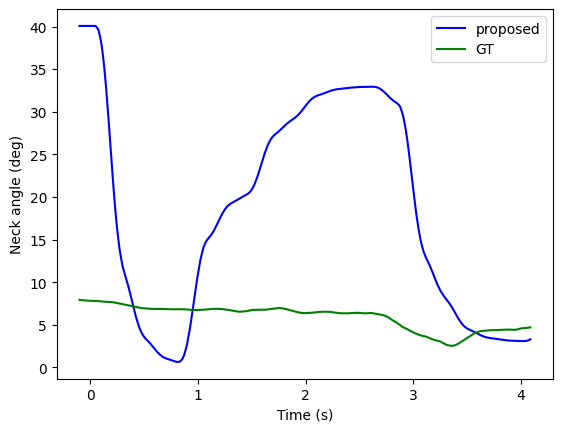

(565, 3)
(565, 3)
proposed: 16.470900669815858
(846, 3)
(846, 3)
oyekoya: 6.105903649821445
yeet


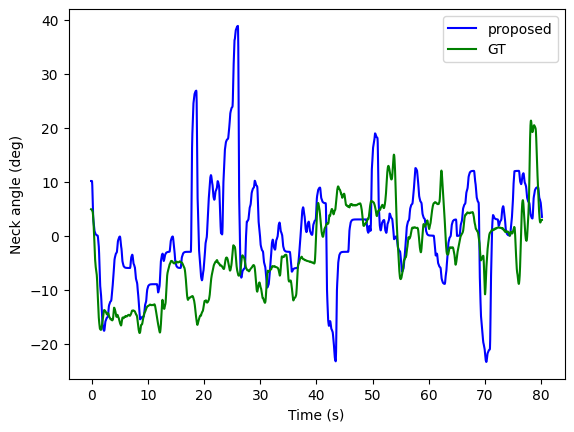

(3595, 3)
(3595, 3)
proposed: 11.13472385838167
(5392, 3)
(5392, 3)
oyekoya: 8.558687039548122
yeet


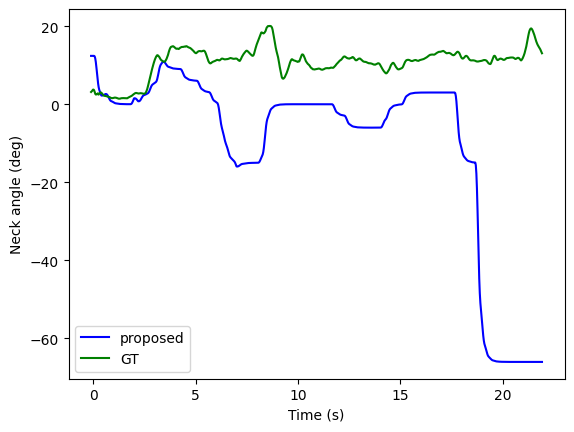

(1141, 3)
(1141, 3)
proposed: 32.506737942478416
(1711, 3)
(1711, 3)
oyekoya: 11.465508083467515
yeet


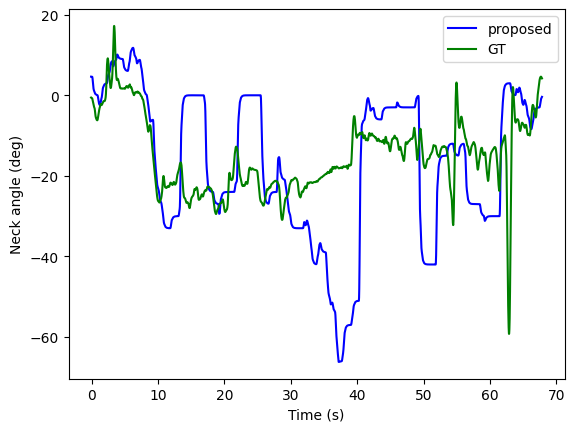

(3107, 3)
(3107, 3)
proposed: 16.81359192128593
(4660, 3)
(4660, 3)
oyekoya: 17.699427435625864


In [106]:
from sklearn.metrics import mean_squared_error
import pandas as pd
target_look_at_error_dict = {}
experiment_names = ["see_through_task"]

nnn = 0
for id_i in range(0, len(input_dirs)):
    experiment_names[nnn]
    input_dir = input_dirs[id_i]
    fileName = recording_file_names[nnn]
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][experiment_names[nnn]][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][experiment_names[nnn]][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    # input_json_0 = ExperimentData(eye_trajectory=eye_trajectory, head_trajectory=head_trajectory, target_trajectory=target_trajectory, input_target_times=target_input["duration"], input_target_angle=target_input["angle"])
    input_json_0 = {"eye_trajectory": eye_trajectory, "head_trajectory": head_trajectory, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
    internal_model_0 = InternalModelFromCapture(input_json_0)
    sequence_0 = []
    for i in range(0, len(input_json_0["input_target_angle"])):
        sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
    input_json = input_json_0
    sequence = sequence_0
    input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
    internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
    for i in range(0, input_sequence.shape[1]):
        input_sequence[1][i] = int(i)
    gaze_positions = []
    for i in range(0, input_sequence.shape[1]):
        gaze_positions.append(internal_model.estimate_target_pose(i))
    # get ground_truth head_keyframes:
    saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
    gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
    # load output motion from proposed graph model
    output_path = os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn]))
    with open(output_path, 'rb') as f:
        proposed_graph_output = pickle.load(f)
        hk_proposed_graph = proposed_graph_output["head_frames"]
        ek_proposed_graph = proposed_graph_output["eye_frames"]
    # load output motion from andrist model
    output_path = os.path.join(OUTPUT_ROOT, "oyekoya_{}_{}.pkl".format(id_i, experiment_names[nnn]))
    with open(output_path, 'rb') as f:
        andrist_output = pickle.load(f)
        hk_andrist = andrist_output["head_frames"]
        ek_andrist = andrist_output["eye_frames"]
    # output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(id_i, experiment_names[nnn])))
    # get oyekoya head_keyframes:
    # output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(id_i, experiment_names[nnn])))    
    # for each model, compute the error and save it in error_dict
    # compare_kf_plot_hk(gt_ek, gt_ek, gt_hk, gt_hk)
    # compare_kf_plot_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph, name2="proposed")
    compare_kf_plot_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph, name2="proposed")
    # compare_kf_plot_ek(gt_ek, ek_andrist, gt_hk, hk_andrist, name2="Andrist")
    print("proposed:", np.sqrt(compare_kf_error_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph)))
    print("oyekoya:", np.sqrt(compare_kf_error_hk(gt_ek, ek_andrist, gt_hk, hk_andrist)))
    

# Perform Hyperparameter Search on different experiments

## load all data to a single arr

In [71]:
eye_trajectory_over_all = []
head_trajectory_over_all = []
for id_i in range(0, len(input_dirs)):
    input_dir = input_dirs[id_i]
    fileName = "wackamole"
    setupFileName = os.path.join(*[input_dir, fileName+".json"])
    # get all the datas
    eye_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][0][0]))
    eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] > 180), 1] - 360
    eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] = eye_trajectory[np.where(eye_trajectory[:, 1] < -180), 1] + 360
    eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] > 180), 2] - 360
    eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] = eye_trajectory[np.where(eye_trajectory[:, 2] < -180), 2] + 360
    head_trajectory = remove_row_containing_nan(np.array(all_trials[id_i][fileName][1][0]))
    head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] = head_trajectory[np.where(head_trajectory[:, 1] > 180), 1] - 360
    head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] = head_trajectory[np.where(head_trajectory[:, 1] < -180), 1] + 360
    head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] = head_trajectory[np.where(head_trajectory[:, 2] > 180), 2] - 360
    head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] = head_trajectory[np.where(head_trajectory[:, 2] < -180), 2] + 360
    min_length_head_and_eye = int(np.minimum(eye_trajectory.shape[0], head_trajectory.shape[0]))
    eye_trajectory = eye_trajectory[:min_length_head_and_eye]
    head_trajectory = head_trajectory[:min_length_head_and_eye]
    eye_trajectory_over_all.append(eye_trajectory)
    head_trajectory_over_all.append(head_trajectory)
eye_trajectory_over_all = np.concatenate(eye_trajectory_over_all, axis=0)
head_trajectory_over_all = np.concatenate(head_trajectory_over_all, axis=0)

input_json = {"eye_trajectory": eye_trajectory_over_all, "head_trajectory": head_trajectory_over_all, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())

for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(internal_model.estimate_target_pose(i))



In [45]:
from itertools import product
def hyperparameter_search(get_optimizer, hyperparameters):
    """
    Perform a hyperparameter search using grid search.

    Parameters:
    model (object): A machine learning model object with a .fit method.
    hyperparameters (dict): A dictionary of hyperparameters to search over.
    X (array-like): The input data for the model.
    y (array-like): The target data for the model.

    Returns:
    best_params (dict): The best hyperparameters found.
    """
    # Get all combinations of hyperparameters
    all_params = product(*hyperparameters.values())

    # Initialize variables to keep track of best model performance
    best_score = float('-inf')
    best_params = None
    values = []
    # Loop over all hyperparameter combinations
    rt_params = []
    for params in all_params:
        # Set hyperparameters for the model
        # print(params)
        print("iteration: ", params)
        model_i = get_optimizer(params)
        input_json = {"eye_trajectory": eye_trajectory_over_all, "head_trajectory": head_trajectory_over_all, "target_trajectory": [], "input_target_times": [], "input_target_angle": []}
        input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
        internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
        saccade_generator_gt = Ground_truth_SacccadeGenerator(input_json=input_json)
        gt_ek, gt_hk, gt_micro_saccade = saccade_generator_gt.compute()
        print("finished ground truth", len(gt_ek), len(gt_hk))
        saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        model_i_outputs = model_i(saccade_generator)
        model_i_outputs = model_i_outputs[1] # 0 is angles, 1 is positions
        ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(model_i_outputs)
        print("finished proposed", len(ek_propsed), len(hk_proposed))
        # Calculate model performance using cross-validation
        mean_score = compare_kf_error_hk(gt_ek, ek_propsed, gt_hk, hk_proposed)
        compare_kf_plot_hk(gt_ek, ek_propsed, gt_hk, hk_proposed)
        # Update best score and parameters if current score is better
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
        values.append(mean_score)
        rt_params.append([params[0], mean_score])
        print(rt_params[-1])
    print(best_params, best_score)
    return best_params, rt_params

In [46]:
import gc
gc.collect()


358997

iteration:  (0.01,)
yeet
finished ground truth 1 1
8131
(8131, 2)
[0.0, 0.16006000000000142]
finished proposed 1 1


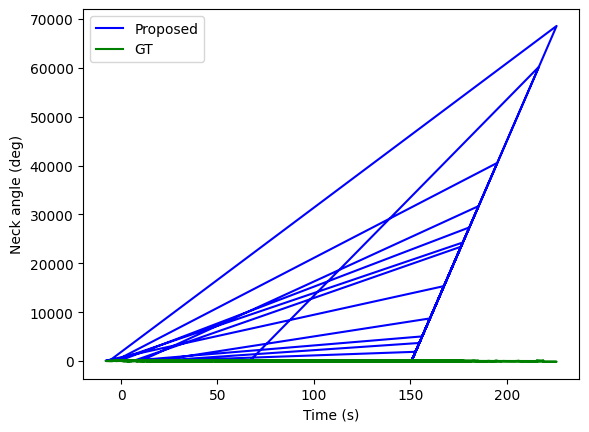

[0.01, 104304624.15188421]
iteration:  (0.2,)
yeet
finished ground truth 1 1
8131
(8131, 2)
[0.0, 0.16006000000000142]


/Users/evanpan/Documents/GitHub/EvansToolBox/Utils/Geometry_Util.py:123: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)


finished proposed 1 1


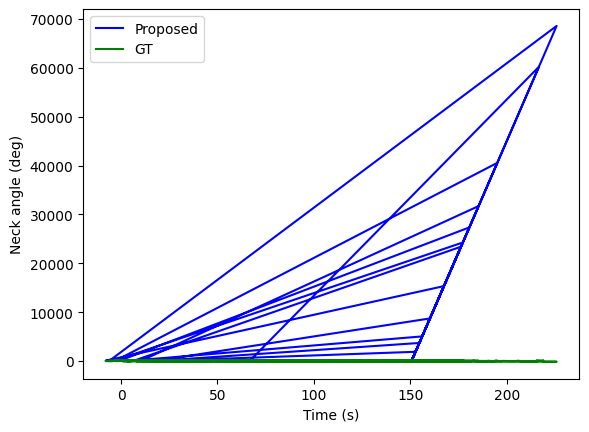

[0.2, 104304763.71844032]
iteration:  (0.5,)
yeet
finished ground truth 1 1
8131
(8131, 2)
[0.0, 0.16006000000000142]


KeyboardInterrupt: 

In [47]:
hyperparameters = {
    'laziness': [0.01, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0],
}
def get_optimizer(weight):
    def optimizer(saccade_generator):
        return optimize_head_pos(saccade_generator, saccade_generator, laziness=weight[0])
    return optimizer
__, output = hyperparameter_search(get_optimizer, hyperparameters)